# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"
import re
import time
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
)
from sklearn.model_selection import train_test_split

import mlflow
from datetime import datetime


from transformers import AutoTokenizer, TFAutoModel

/opt/anaconda3/envs/p7_bert/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import tensorflow as tf

import mlflow.tensorflow

In [4]:
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW

In [5]:
print(f"Python {sys.version}")

Python 3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:56:31) [Clang 19.1.7 ]


In [6]:
print("TF:", tf.__version__)
print("GPU physiques:", tf.config.list_physical_devices("GPU"))
print("GPU logiques:", tf.config.list_logical_devices("GPU"))

TF: 2.15.0
GPU physiques: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU logiques: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2025-11-07 10:31:35.125387: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-07 10:31:35.125430: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-07 10:31:35.125436: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-07 10:31:35.126024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-07 10:31:35.126452: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
mlflow.__version__

'3.5.1'

In [8]:
VOCAB_SIZE = None
MAX_TWEET_LENGTH = 50
BATCH_SIZE = 128
EPOCHS = 20
EMBEDDING_DIM = 32

In [9]:
df_train = pd.read_csv("train_50K.csv")
df_val = pd.read_csv("val_50K.csv")
df_test = pd.read_csv("test_50K.csv")
df_train.shape, df_val.shape, df_test.shape

FileNotFoundError: [Errno 2] No such file or directory: 'train_50K.csv'

In [ ]:
def soft_preprocess(text):
    # Minuscules
    text = str(text).lower()
    # Supprimer mentions
    text = re.sub(r"@\w+", "", text)
    # Supprimer uniquenment #
    text = re.sub(r"#(\w+)", r"\1", text)
    # Supprimer mots d'1 lettre
    # text = re.sub(r"\b[a-z]\b", "", text)
    # Nettoyer espaces multiples
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
df_train["text"] = df_train["text"].apply(soft_preprocess)
df_test["text"] = df_test["text"].apply(soft_preprocess)
df_val["text"] = df_val["text"].apply(soft_preprocess)

In [ ]:
df_train["text"]

0        very excited for new moon trailer although i w...
1                  rediscovering my love for missy higgins
2        aww. babe juss called juss cuz he lovez me. ju...
3        5 brothers &amp; a million sisters gets better...
4            going to go see terri,jimmy,&amp;jennifer....
                               ...                        
31995    i'm sick and tired of twitter because of so ma...
31996    briefs and socks. and of course phoebe's hoodi...
31997    final cut crashed and deleted all my captured ...
31998                yeah mate im coming in at about 11:45
31999                when do we get to hear body control??
Name: text, Length: 32000, dtype: object

# LSTM Simple

In [45]:
# Vectorizer
text_vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_TWEET_LENGTH,  # padding
    #     # standardize="lower",
    #     standardize="lower_and_strip_punctuation",
    #     split="whitespace",
)

In [46]:
text_vectorizer.adapt(df_train["text"].values)
vocab_size = len(text_vectorizer.get_vocabulary())
VOCAB_SIZE = vocab_size
print(f" Vocabulaire: {vocab_size} mots")

 Vocabulaire: 32890 mots


In [47]:
# Créer pipeline tensorflow pour optimser le temps d'execution
def make_dataset(df, shuffle=True):
    texts = df["text"].values
    labels = df["target"].values

    dataset = tf.data.Dataset.from_tensor_slices(
        (texts, labels)
    )  # Créer dataset tensorflow => data en paire (texts, labels) => optimisé le traitement
    if shuffle:
        # SHUFFLE = Mélange les données pour éviter overfit par ordre
        # Évite que le modèle mémorise l'ordre des exemples au lieu des patterns
        # Buffer_size = 10000 → garde 10,000 exemples en mémoire pour mélange
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(BATCH_SIZE).prefetch(
        tf.data.AUTOTUNE
    )  # prefetch GPU calcule batch 1 // CPU prépare batch2 => gain de temps d'execution, AUTOTUNE=>s'adapte à GPU M2
    return dataset

In [48]:
data_train = make_dataset(df_train, shuffle=True)
data_train_eval = make_dataset(
    df_train, shuffle=False
)  # eval de train => mm ordre que y_true
data_val = make_dataset(df_val, shuffle=False)
data_test = make_dataset(df_test, shuffle=False)

In [25]:
# Configuration MLflow
experiment_name = "p7_air_paradis"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/skanderzahi/Desktop/P7/projet/mlruns/379503310426968982', creation_time=1760449044952, experiment_id='379503310426968982', last_update_time=1760449044952, lifecycle_stage='active', name='p7_air_paradis', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [50]:
# Run mlflow
with mlflow.start_run(
    run_name=f"DL_LSTM_recurrent_dropout_softPreProcess_{VOCAB_SIZE}"
):

    # Enregistrement du temps de début
    start_time = time.time()

    # Log des paramètres
    params = {
        "vocab_size": VOCAB_SIZE,
        "max_length": MAX_TWEET_LENGTH,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "embedding_dim": EMBEDDING_DIM,
        "optimizer": "AdamW",
        "loss": "binary_crossentropy",
        "train_samples": len(df_train),
        "val_samples": len(df_val),
        "test_samples": len(df_test),
        "architecture": "LSTM_Simple",
        "gpu": "Apple M2",
    }

    mlflow.log_params(params)

    # Construction du modèle
    model = models.Sequential(
        [
            layers.Input(shape=(1,), dtype=tf.string),
            text_vectorizer,
            layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=EMBEDDING_DIM,
                mask_zero=True,  # ignorer le padding
                name="embedding",
            ),
            # LSTM
            layers.LSTM(
                64,
                dropout=0.2,
                return_sequences=False,  # Retourne seulement le dernier output par defaut
                # recurrent_dropout=0.2,  # Régularisation sur connexions récurrentes !!!! temps d'execution trop long
            ),
            # Pas de GAP car LSTM fait déjà la réduction
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.4),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(1, activation="sigmoid"),
        ],
        name="ml_lstm_simple",
    )

    # Compilation du modèle
    model.compile(
        loss="binary_crossentropy",
        optimizer=AdamW(learning_rate=0.001),
        metrics=["accuracy"],
    )

    model.summary()

    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=1,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            verbose=1,
        ),
    ]

    # Entraînement
    history = model.fit(
        data_train,
        validation_data=data_val,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )
    print("ok train")

    # Temps d'entraînement
    training_time = time.time() - start_time
    mlflow.log_metric("training_time_seconds", training_time)
    print(f"Entrainement terminé => {training_time:.2f} secondes")

    # Nombre d'époques réelles
    actual_epochs = len(history.history["loss"])
    mlflow.log_metric("actual_epochs", actual_epochs)
    print(
        f"\nLogging de {actual_epochs} époques (EarlyStopping peut avoir arrêté avant {EPOCHS})"
    )

    # Log des métriques par époque
    for epoch in range(actual_epochs):
        mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
        mlflow.log_metric(
            "train_accuracy", history.history["accuracy"][epoch], step=epoch
        )
        mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
        mlflow.log_metric(
            "val_accuracy", history.history["val_accuracy"][epoch], step=epoch
        )

    # Évaluation avec model.evaluate()
    train_loss, train_accuracy = model.evaluate(data_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(data_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(data_test, verbose=0)

    # Log des métriques de base
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    print(f"\nTrain - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    print(f"Test  - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

    # Prédictions pour métriques avancées
    y_train_pred_proba = model.predict(data_train_eval, verbose=0).flatten()  #####
    # y_train_pred_proba = model.predict(df_train, verbose=0).flatten()#####
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)
    y_train_true = df_train["target"].values

    y_val_pred_proba = model.predict(data_val, verbose=0).flatten()
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    y_val_true = df_val["target"].values

    y_test_pred_proba = model.predict(data_test, verbose=0).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)
    y_test_true = df_test["target"].values

    # Fonction de calcul des métriques avancées
    def calcul_metriques(y_true, y_pred, y_pred_proba):
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        return precision, recall, f1, roc_auc

    # Calcul des métriques
    train_precision, train_recall, train_f1, train_roc_auc = calcul_metriques(
        y_train_true, y_train_pred, y_train_pred_proba
    )

    val_precision, val_recall, val_f1, val_roc_auc = calcul_metriques(
        y_val_true, y_val_pred, y_val_pred_proba
    )

    test_precision, test_recall, test_f1, test_roc_auc = calcul_metriques(
        y_test_true, y_test_pred, y_test_pred_proba
    )

    # Log des métriques
    # Train
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("train_roc_auc", train_roc_auc)

    # Val
    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)

    # Test
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    # Métriques d'overfitting
    mlflow.log_metric("train_val_accuracy_gap", train_accuracy - val_accuracy)
    mlflow.log_metric("val_test_accuracy_gap", val_accuracy - test_accuracy)
    mlflow.log_metric("train_val_f1_gap", train_f1 - val_f1)
    mlflow.log_metric("val_test_f1_gap", val_f1 - test_f1)

    # Visualisation - Accuracy et Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    epochs_range = range(1, actual_epochs + 1)

    # Accuracy
    ax1.plot(
        epochs_range,
        history.history["accuracy"],
        "b-",
        label="Train Accuracy",
        linewidth=2,
    )
    ax1.plot(
        epochs_range,
        history.history["val_accuracy"],
        "r:",
        label="Val Accuracy",
        linewidth=2,
    )
    ax1.set_title("Accuracy Train - Val")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(
        epochs_range, history.history["loss"], "b-", label="Train Loss", linewidth=2
    )
    ax2.plot(
        epochs_range, history.history["val_loss"], "r:", label="Val Loss", linewidth=2
    )
    ax2.set_title("Loss Train - Val")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("training_history.png")
    mlflow.log_artifact("training_history.png")
    plt.close()

    # Courbe ROC pour train, val, test
    plt.figure(figsize=(8, 6))
    for y_true, y_proba, label, color in [
        (y_train_true, y_train_pred_proba, "Train", "blue"),
        (y_val_true, y_val_pred_proba, "Validation", "green"),
        (y_test_true, y_test_pred_proba, "Test", "red"),
    ]:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - Train/Validation/Test")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    plt.savefig("roc_curve_comparaison.png")
    mlflow.log_artifact("roc_curve_comparaison.png")
    plt.close()

    # Sauvegarde du modèle
    mlflow.tensorflow.log_model(
        model,
        name="model",
        registered_model_name=f"DL_LSTM_softPreProcess_{VOCAB_SIZE}",
    )

    # Tags
    mlflow.set_tags(
        {
            "model_type": "ML_avance",
            "architecture": "lstm_simple",
            "dataset": "twitter_50K",
        }
    )

Model: "ml_lstm_simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (Text  (None, 50)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 50, 32)            1052480   
                                                                 
 lstm_5 (LSTM)               (None, 64)                24832     
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                    

2025/10/23 23:36:59 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/3g/rdq178bx3690jwjlb35tlzqw0000gp/T/tmp1nwsmpct/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/3g/rdq178bx3690jwjlb35tlzqw0000gp/T/tmp1nwsmpct/model/data/model/assets
2025/10/23 23:37:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/3g/rdq178bx3690jwjlb35tlzqw0000gp/T/tmp1nwsmpct/model, flavor: tensorflow). Fall back to return ['tensorflow==2.20.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/10/23 23:37:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'DL_LSTM_softPreProcess_32890' already exists. Creating a new version of this model...
Created version '4' of model 'DL_LSTM_softPreProcess_32890'.


# LSTM Bidirectionnel

In [51]:
# Run mlflow
with mlflow.start_run(run_name=f"DL_LSTM_Bidirectionnel_softPreProcess_{VOCAB_SIZE}"):

    # Enregistrement du temps de début
    start_time = time.time()

    # Log des paramètres
    params = {
        "vocab_size": VOCAB_SIZE,
        "max_length": MAX_TWEET_LENGTH,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "embedding_dim": EMBEDDING_DIM,
        "optimizer": "AdamW",
        "loss": "binary_crossentropy",
        "train_samples": len(df_train),
        "val_samples": len(df_val),
        "test_samples": len(df_test),
        "architecture": "LSTM_Bidirectionnel",
        "gpu": "Apple M2",
        "bidirectional": True,
    }

    mlflow.log_params(params)

    # Construction du modèle
    model = models.Sequential(
        [
            layers.Input(shape=(1,), dtype=tf.string),
            text_vectorizer,
            layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=EMBEDDING_DIM,
                mask_zero=True,  # ignorer le padding
                name="embedding",
            ),
            layers.SpatialDropout1D(
                0.2
            ),  # régularise les embeddings (eteint des canaux entiers(dimensionde l'embedding) X Dropout eteint des positions individuel aléatoires)
            # LSTM
            layers.Bidirectional(
                layers.LSTM(
                    64,
                    dropout=0.2,
                    return_sequences=False,  # Retourne seulement le dernier output par defaut
                ),
                name="bilstm",
            ),
            # Sortie bilstm est de dimension => 64*2=128
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.4),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(1, activation="sigmoid"),
        ],
        name="ml_bilstm",
    )

    # Compilation du modèle
    model.compile(
        loss="binary_crossentropy",
        optimizer=AdamW(learning_rate=5e-4),
        metrics=["accuracy"],
    )

    model.summary()

    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=1,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            verbose=1,
        ),
    ]

    # Entraînement
    history = model.fit(
        data_train,
        validation_data=data_val,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )
    print("ok train")

    # Temps d'entraînement
    training_time = time.time() - start_time
    mlflow.log_metric("training_time_seconds", training_time)
    print(f"Entrainement terminé => {training_time:.2f} secondes")

    # Nombre d'époques réelles
    actual_epochs = len(history.history["loss"])
    mlflow.log_metric("actual_epochs", actual_epochs)
    print(
        f"\nLogging de {actual_epochs} époques (EarlyStopping peut avoir arrêté avant {EPOCHS})"
    )

    # Log des métriques par époque
    for epoch in range(actual_epochs):
        mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
        mlflow.log_metric(
            "train_accuracy", history.history["accuracy"][epoch], step=epoch
        )
        mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
        mlflow.log_metric(
            "val_accuracy", history.history["val_accuracy"][epoch], step=epoch
        )

    # Évaluation avec model.evaluate()
    train_loss, train_accuracy = model.evaluate(data_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(data_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(data_test, verbose=0)

    # Log des métriques de base
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    print(f"\nTrain - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    print(f"Test  - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

    # Prédictions pour métriques avancées
    y_train_pred_proba = model.predict(data_train_eval, verbose=0).flatten()
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)
    y_train_true = df_train["target"].values

    y_val_pred_proba = model.predict(data_val, verbose=0).flatten()
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    y_val_true = df_val["target"].values

    y_test_pred_proba = model.predict(data_test, verbose=0).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)
    y_test_true = df_test["target"].values

    # Fonction de calcul des métriques avancées
    def calcul_metriques(y_true, y_pred, y_pred_proba):
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        return precision, recall, f1, roc_auc

    # Calcul des métriques
    train_precision, train_recall, train_f1, train_roc_auc = calcul_metriques(
        y_train_true, y_train_pred, y_train_pred_proba
    )

    val_precision, val_recall, val_f1, val_roc_auc = calcul_metriques(
        y_val_true, y_val_pred, y_val_pred_proba
    )

    test_precision, test_recall, test_f1, test_roc_auc = calcul_metriques(
        y_test_true, y_test_pred, y_test_pred_proba
    )

    # Log des métriques
    # Train
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("train_roc_auc", train_roc_auc)

    # Val
    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)

    # Test
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    # Métriques d'overfitting
    mlflow.log_metric("train_val_accuracy_gap", train_accuracy - val_accuracy)
    mlflow.log_metric("val_test_accuracy_gap", val_accuracy - test_accuracy)
    mlflow.log_metric("train_val_f1_gap", train_f1 - val_f1)
    mlflow.log_metric("val_test_f1_gap", val_f1 - test_f1)

    # Visualisation - Accuracy et Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    epochs_range = range(1, actual_epochs + 1)

    # Accuracy
    ax1.plot(
        epochs_range,
        history.history["accuracy"],
        "b-",
        label="Train Accuracy",
        linewidth=2,
    )
    ax1.plot(
        epochs_range,
        history.history["val_accuracy"],
        "r:",
        label="Val Accuracy",
        linewidth=2,
    )
    ax1.set_title("Accuracy Train - Val")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(
        epochs_range, history.history["loss"], "b-", label="Train Loss", linewidth=2
    )
    ax2.plot(
        epochs_range, history.history["val_loss"], "r:", label="Val Loss", linewidth=2
    )
    ax2.set_title("Loss Train - Val")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("training_history.png")
    mlflow.log_artifact("training_history.png")
    plt.close()

    # Courbe ROC pour train, val, test
    plt.figure(figsize=(8, 6))
    for y_true, y_proba, label, color in [
        (y_train_true, y_train_pred_proba, "Train", "blue"),
        (y_val_true, y_val_pred_proba, "Validation", "green"),
        (y_test_true, y_test_pred_proba, "Test", "red"),
    ]:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - Train/Validation/Test")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    plt.savefig("roc_curve_comparaison.png")
    mlflow.log_artifact("roc_curve_comparaison.png")
    plt.close()

    # Sauvegarde du modèle
    mlflow.tensorflow.log_model(
        model,
        name="model",
        registered_model_name=f"DL_LSTM_softPreProcess_{VOCAB_SIZE}",
    )

    # Tags
    mlflow.set_tags(
        {
            "model_type": "ML_avance",
            "architecture": "Bi_lstm",
            "dataset": "twitter_50K",
        }
    )

Model: "ml_bilstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (Text  (None, 50)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 50, 32)            1052480   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 32)            0         
 Dropout1D)                                                      
                                                                 
 bilstm (Bidirectional)      (None, 128)               49664     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0 

2025/10/24 04:00:54 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/3g/rdq178bx3690jwjlb35tlzqw0000gp/T/tmp8ammt028/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/3g/rdq178bx3690jwjlb35tlzqw0000gp/T/tmp8ammt028/model/data/model/assets
2025/10/24 04:17:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/3g/rdq178bx3690jwjlb35tlzqw0000gp/T/tmp8ammt028/model, flavor: tensorflow). Fall back to return ['tensorflow==2.20.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/10/24 04:17:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'DL_LSTM_softPreProcess_32890' already exists. Creating a new version of this model...
Created version '5' of model 'DL_LSTM_softPreProcess_32890'.


# DistilBert

In [12]:
MODEL_NAME = "distilbert-base-uncased"

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
distilbert_model = TFAutoModel.from_pretrained(
    MODEL_NAME,
    use_safetensors=False,
    # from_pt=True
)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was

In [14]:
print(f"DistilBERT chargé : {distilbert_model.num_parameters():,} paramètres")

DistilBERT chargé : 66,362,880 paramètres


In [15]:
# Tokenisation
MAX_LENGTH = 128  # Longueur imposée des tweets
BATCH_SIZE = 16

In [16]:
# Fonction de tokenisation avec le tokenizer DistilBERT
def tokenize_texts(texts, tokenizer, max_length):
    return tokenizer(
        texts.tolist(),
        padding="max_length",  # Ajouter du padding pour atteindre max_length
        truncation=True,
        max_length=max_length,  # Longueur fixe
        return_tensors="tf",
    )  # return= dic avec input_ids et attention_mask

In [17]:
# Tokenisationd des 3 sets
train_encodings = tokenize_texts(df_train["text"], tokenizer, MAX_LENGTH)
val_encodings = tokenize_texts(df_val["text"], tokenizer, MAX_LENGTH)
test_encodings = tokenize_texts(df_test["text"], tokenizer, MAX_LENGTH)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [18]:
train_encodings

{'input_ids': <tf.Tensor: shape=(32000, 128), dtype=int32, numpy=
array([[  101,  2200,  7568, ...,     0,     0,     0],
       [  101,  2417,  2483, ...,     0,     0,     0],
       [  101, 22091,  2860, ...,     0,     0,     0],
       ...,
       [  101,  2345,  3013, ...,     0,     0,     0],
       [  101,  3398,  6775, ...,     0,     0,     0],
       [  101,  2043,  2079, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(32000, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [19]:
train_encodings["input_ids"][0]
# 101 => id token debut
# 2200 ... 21807 => id  token mots
# 102 => id Token fin
# 0 padding

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101,  2200,  7568,  2005,  2047,  4231,  9117,  2348,  1045,
        2097,  2031,  2000,  3422,  2009,  2043,  1045,  5256,  2039,
        3419,  2080, 22822,  2078,  1012,  1045,  5223,  2051,  4487,
       21807,   102,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   

In [20]:
train_encodings["attention_mask"][0]
# 1 token réel
# 0 padding

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [21]:
# Création des datasets TensorFlow
def create_dataset(encodings, labels, batch_size, shuffle=False):

    # Créer le dataset avec input_ids, attention_mask et labels
    dataset = tf.data.Dataset.from_tensor_slices(
        (
            {
                "input_ids": encodings["input_ids"],
                "attention_mask": encodings["attention_mask"],
            },
            labels,
        )
    )  # => Tuple (features_dict, label)

    # Mélange si True
    if shuffle:
        dataset = dataset.shuffle(10000, seed=42)

    # Créer des batchs
    dataset = dataset.batch(batch_size)

    # prefetch pour optimiser
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [22]:
# Création des 3 datasets
data_train = create_dataset(
    train_encodings, df_train["target"].values, BATCH_SIZE, shuffle=True
)
data_val = create_dataset(val_encodings, df_val["target"].values, BATCH_SIZE)
data_test = create_dataset(test_encodings, df_test["target"].values, BATCH_SIZE)
# Utile pour eval train avec aligenemnt target
data_train_eval = create_dataset(train_encodings, df_train["target"].values, BATCH_SIZE)

# Test 

In [96]:
# Modèle

# Definir les entrées => input_ids et attention_mask
input_ids = layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="input_ids")
attention_mask = layers.Input(
    shape=(MAX_LENGTH,), dtype=tf.int32, name="attention_mask"
)
# Creer embeddings distilbert
distilbert_output = distilbert_model(input_ids=input_ids, attention_mask=attention_mask)
distilbert_output
# Chaque tweet 128 tokens
# Chaque token 768 dimensions

TFBaseModelOutput(last_hidden_state=<KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'tf_distil_bert_model_9')>, hidden_states=None, attentions=None)

In [98]:
# Extraire le token de classification
cls_token = distilbert_output.last_hidden_state[:, 0, :]
# [tweet, 0 =>1er token de cls, dim]
# token cls : resume, capture emb
cls_token

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf.__operators__.getitem_2')>

In [102]:
# Couches de classification
x = layers.Dropout(0.2)(cls_token)  # Dropout 0.2
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.1)(x)  # Dropout 0.1
outputs = layers.Dense(1, activation="sigmoid")(x)

# Création du modèle
model = models.Model(
    inputs=[input_ids, attention_mask],  # 2 entrées
    outputs=outputs,
    name="distilbert_sentiment",
)

# Optimiseur AdamW avec weight decay
optimizer = AdamW(
    learning_rate=3e-5,
)

# Compilation
model.compile(
    loss="binary_crossentropy",  # Loss pour classification binaire
    optimizer=optimizer,
    metrics=["accuracy"],
)
model.summary()

Model: "distilbert_sentiment"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model_9 (TF  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 DistilBertModel)            den_state=(None, 128, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                        

In [ ]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True,
        verbose=1,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=1,
        verbose=1,
    ),
]

In [ ]:
EPOCHS = 3
# Entraînement
history = model.fit(
    data_train,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

# MLflow

In [12]:
# Configuration MLflow
experiment_name = "p7_air_paradis"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/skanderzahi/Desktop/P7/projet/mlruns/379503310426968982', creation_time=1760449044952, experiment_id='379503310426968982', last_update_time=1760449044952, lifecycle_stage='active', name='p7_air_paradis', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [54]:
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 3e-5

## DistilBert gelé

In [79]:
# Fonction signature
def create_model_signature(model, train_encodings):
    # sample_input = {
    #     "input_ids": np.array(train_encodings["input_ids"][:2]),
    #     "attention_mask": np.array(train_encodings["attention_mask"][:2]),
    # }
    sample_input = [
        np.array(train_encodings["input_ids"][:2]),
        np.array(train_encodings["attention_mask"][:2]),
    ]
    sample_output = model.predict(sample_input, verbose=0)
    from mlflow.models import infer_signature

    signature = infer_signature(sample_input, sample_output)
    return signature, sample_input

In [80]:
with mlflow.start_run(
    run_name=f"DL_DistilBERT_trainable_False_EPOCHS_{EPOCHS}_{MAX_LENGTH}"
):

    # Enregistrement du temps de début
    start_time = time.time()

    # Log des paramètres
    params = {
        "max_length": MAX_LENGTH,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "optimizer": "AdamW",
        "learning_rate": LEARNING_RATE,
        "loss": "binary_crossentropy",
        "train_samples": len(df_train),
        "val_samples": len(df_val),
        "test_samples": len(df_test),
        "architecture": "DistilBERT",
        "model_name": "distilbert-base-uncased",
        "distilbert_trainable": False,
        "dropout_1": 0.2,
        "dropout_2": 0.1,
        "dense_units": 128,
        "gpu": "Apple M2",
    }

    mlflow.log_params(params)

    # Construction du modèle

    # DistilBert gelé
    distilbert_model.trainable = False
    # Inputs
    input_ids = layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="input_ids")
    attention_mask = layers.Input(
        shape=(MAX_LENGTH,), dtype=tf.int32, name="attention_mask"
    )

    # DistilBERT
    distilbert_output = distilbert_model(
        input_ids=input_ids, attention_mask=attention_mask
    )
    cls_token = distilbert_output.last_hidden_state[:, 0, :]

    # Couches de classification
    x = layers.Dropout(0.2)(cls_token)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(1, activation="sigmoid")(x)

    # Création du modèle
    model = models.Model(
        inputs=[input_ids, attention_mask], outputs=output, name="DistilBERT_Classifier"
    )

    # Compilation
    optimizer = AdamW(learning_rate=LEARNING_RATE)
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )

    model.summary()

    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=1,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,  # Réduit le LR de moitié
            patience=3,
            verbose=1,
            min_lr=1e-7,  # LR minimum
        ),
    ]

    # Entraînement
    history = model.fit(
        data_train,
        validation_data=data_val,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )
    print("ok train")

    # Temps d'entraînement
    training_time = time.time() - start_time
    mlflow.log_metric("training_time_seconds", training_time)
    print(f"Temps d'entraînement : {training_time:.2f} secondes")

    # Nombre d'époques réelles
    actual_epochs = len(history.history["loss"])
    mlflow.log_metric("actual_epochs", actual_epochs)
    print(
        f"\nLogging de {actual_epochs} époques "
        f"(EarlyStopping peut avoir arrêté avant {EPOCHS})"
    )

    # Log des métriques par époque
    for epoch in range(actual_epochs):
        mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
        mlflow.log_metric(
            "train_accuracy", history.history["accuracy"][epoch], step=epoch
        )
        mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
        mlflow.log_metric(
            "val_accuracy", history.history["val_accuracy"][epoch], step=epoch
        )

    # Évaluation avec model.evaluate()
    train_loss, train_accuracy = model.evaluate(data_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(data_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(data_test, verbose=0)

    # Log des métriques de base
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    print(f"\nMétriques finales :")
    print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    print(f"Test  - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

    # Prédictions pour métriques avancées
    y_train_pred_proba = model.predict(data_train_eval, verbose=0).flatten()
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)
    y_train_true = df_train["target"].values

    y_val_pred_proba = model.predict(data_val, verbose=0).flatten()
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    y_val_true = df_val["target"].values

    y_test_pred_proba = model.predict(data_test, verbose=0).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)
    y_test_true = df_test["target"].values

    # Fonction de calcul des métriques avancées
    def calcul_metriques(y_true, y_pred, y_pred_proba):
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        return precision, recall, f1, roc_auc

    # Calcul des métriques
    train_precision, train_recall, train_f1, train_roc_auc = calcul_metriques(
        y_train_true, y_train_pred, y_train_pred_proba
    )

    val_precision, val_recall, val_f1, val_roc_auc = calcul_metriques(
        y_val_true, y_val_pred, y_val_pred_proba
    )

    test_precision, test_recall, test_f1, test_roc_auc = calcul_metriques(
        y_test_true, y_test_pred, y_test_pred_proba
    )

    # Log des métriques
    # Train
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("train_roc_auc", train_roc_auc)

    # Validation
    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)

    # Test
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    # Métriques d'overfitting
    mlflow.log_metric("train_val_accuracy_gap", train_accuracy - val_accuracy)
    mlflow.log_metric("val_test_accuracy_gap", val_accuracy - test_accuracy)
    mlflow.log_metric("train_val_f1_gap", train_f1 - val_f1)
    mlflow.log_metric("val_test_f1_gap", val_f1 - test_f1)

    # Visualisation - Accuracy et Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    epochs_range = range(1, actual_epochs + 1)

    # Accuracy
    ax1.plot(
        epochs_range,
        history.history["accuracy"],
        "b-",
        label="Train Accuracy",
        linewidth=2,
    )
    ax1.plot(
        epochs_range,
        history.history["val_accuracy"],
        "r:",
        label="Val Accuracy",
        linewidth=2,
    )
    ax1.set_title("Accuracy Train - Val")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(
        epochs_range, history.history["loss"], "b-", label="Train Loss", linewidth=2
    )
    ax2.plot(
        epochs_range, history.history["val_loss"], "r:", label="Val Loss", linewidth=2
    )
    ax2.set_title("Loss Train - Val")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("training_history.png")
    mlflow.log_artifact("training_history.png")
    plt.close()

    # Courbe ROC pour train, val, test
    plt.figure(figsize=(8, 6))
    for y_true, y_proba, label, color in [
        (y_train_true, y_train_pred_proba, "Train", "blue"),
        (y_val_true, y_val_pred_proba, "Validation", "green"),
        (y_test_true, y_test_pred_proba, "Test", "red"),
    ]:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - DistilBERT Sentiment Analysis")
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("distilbert_roc_curve_comparaison.png")
    mlflow.log_artifact("distilbert_roc_curve_comparaison.png")
    plt.close()

    # Créer la signature
    signature, input_example = create_model_signature(model, train_encodings)

    # Sauvegarder le tokenizer
    tokenizer.save_pretrained("temp_tokenizer")
    mlflow.log_artifacts("temp_tokenizer", artifact_path="tokenizer")
    print("\nTokenizer sauvegardé")

    # Sauvegarde du modèle
    mlflow.tensorflow.log_model(
        model,
        artifact_path="model",
        registered_model_name=f"DistilBERT_{MAX_LENGTH}",
        signature=signature,
        input_example=None,
        pip_requirements=[
            f"tensorflow=={tf.__version__}",
            "transformers==4.35.2",
        ],
    )
    print("\nModèle sauvegardé")

    # Tags
    mlflow.set_tags(
        {
            "model_type": "ML_avance",
            "architecture": "DistilBERT",
            "dataset": "twitter_50K",
        }
    )

Model: "DistilBERT_Classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 DistilBertModel)            den_state=(None, 128, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                       

2025/11/04 20:33:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Tokenizer sauvegardé


MlflowException: All fields in the model signature's input schema must be of type TensorSpec.

In [84]:
pd.set_option("display.max_colwidth", None)

In [85]:
df_train["text"].head(1)

0    very excited for new moon trailer although i will have to watch it when i wake up tomo morn. i hate time diffs
Name: text, dtype: object

## DistilBert trainable

In [23]:
LEARNING_RATE = 3e-5
EPOCHS = 3
MAX_LENGTH = 128
BATCH_SIZE = 16

Model: "DistilBERT_Classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 128, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                       

2025-11-04 23:44:59.328096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2000/2000 [==============================] - 8660s 4s/step - loss: 0.4451 - accuracy: 0.7938 - val_loss: 0.3886 - val_accuracy: 0.8270 - lr: 3.0000e-05
Epoch 2/3
2000/2000 [==============================] - 3735s 2s/step - loss: 0.3315 - accuracy: 0.8579 - val_loss: 0.4001 - val_accuracy: 0.8245 - lr: 3.0000e-05
Epoch 3/3
2000/2000 [==============================] - 8449s 4s/step - loss: 0.2105 - accuracy: 0.9152 - val_loss: 0.4591 - val_accuracy: 0.8194 - lr: 3.0000e-05
ok train
Temps d'entraînement : 20845.96 secondes

Logging de 3 époques (EarlyStopping peut avoir arrêté avant 3)

Métriques finales :
Train - Loss: 0.0841, Accuracy: 0.9766
Val   - Loss: 0.4591, Accuracy: 0.8194
Test  - Loss: 0.4717, Accuracy: 0.8166


MlflowException: When an mlflow-artifacts URI was supplied, the tracking URI must be a valid http or https URI, but it was currently set to file:///Users/skanderzahi/Desktop/P7/projet/mlruns. Perhaps you forgot to set the tracking URI to the running MLflow server. To set the tracking URI, use either of the following methods:
1. Set the MLFLOW_TRACKING_URI environment variable to the desired tracking URI. `export MLFLOW_TRACKING_URI=http://localhost:5000`
2. Set the tracking URI programmatically by calling `mlflow.set_tracking_uri`. `mlflow.set_tracking_uri('http://localhost:5000')`

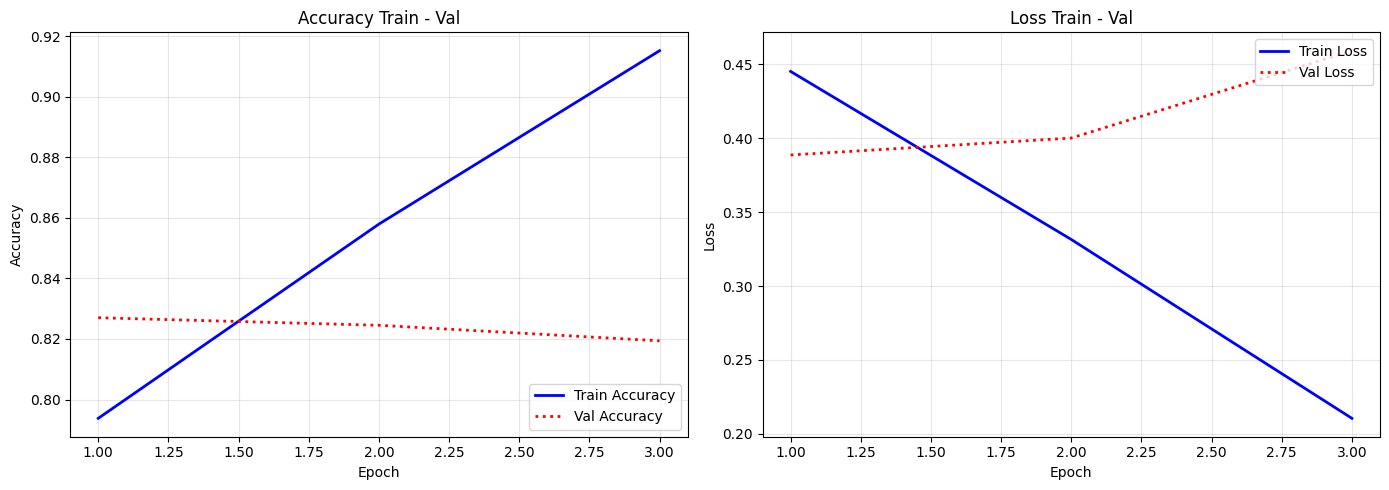

In [ ]:
with mlflow.start_run(run_name=f"DL_DistilBERT_trainable_EPOCHS_{EPOCHS}_{MAX_LENGTH}"):

    # Enregistrement du temps de début
    start_time = time.time()

    # Log des paramètres
    params = {
        "max_length": MAX_LENGTH,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "optimizer": "AdamW",
        "learning_rate": LEARNING_RATE,
        "loss": "binary_crossentropy",
        "train_samples": len(df_train),
        "val_samples": len(df_val),
        "test_samples": len(df_test),
        "architecture": "DistilBERT",
        "model_name": "distilbert-base-uncased",
        "distilbert_trainable": True,
        "dropout_1": 0.2,
        "dropout_2": 0.1,
        "dense_units": 128,
        "gpu": "Apple M2",
    }

    mlflow.log_params(params)

    # Construction du modèle
    # DistilBert dégelé
    distilbert_model.trainable = True

    # Inputs
    input_ids = layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="input_ids")
    attention_mask = layers.Input(
        shape=(MAX_LENGTH,), dtype=tf.int32, name="attention_mask"
    )

    # DistilBERT
    distilbert_output = distilbert_model(
        input_ids=input_ids, attention_mask=attention_mask
    )
    cls_token = distilbert_output.last_hidden_state[:, 0, :]

    # Couches de classification
    x = layers.Dropout(0.2)(cls_token)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(1, activation="sigmoid")(x)

    # Création du modèle
    model = models.Model(
        inputs=[input_ids, attention_mask], outputs=output, name="DistilBERT_Classifier"
    )

    # Compilation
    optimizer = AdamW(learning_rate=LEARNING_RATE)
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )

    model.summary()

    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=1,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,  # Réduit le LR de moitié
            patience=3,
            verbose=1,
            min_lr=1e-7,  # LR minimum
        ),
    ]

    # Entraînement
    history = model.fit(
        data_train,
        validation_data=data_val,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )
    print("ok train")

    # Temps d'entraînement
    training_time = time.time() - start_time
    mlflow.log_metric("training_time_seconds", training_time)
    print(f"Temps d'entraînement : {training_time:.2f} secondes")

    # Nombre d'époques réelles
    actual_epochs = len(history.history["loss"])
    mlflow.log_metric("actual_epochs", actual_epochs)
    print(
        f"\nLogging de {actual_epochs} époques "
        f"(EarlyStopping peut avoir arrêté avant {EPOCHS})"
    )

    # Log des métriques par époque
    for epoch in range(actual_epochs):
        mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
        mlflow.log_metric(
            "train_accuracy", history.history["accuracy"][epoch], step=epoch
        )
        mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
        mlflow.log_metric(
            "val_accuracy", history.history["val_accuracy"][epoch], step=epoch
        )

    # Évaluation avec model.evaluate()
    train_loss, train_accuracy = model.evaluate(data_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(data_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(data_test, verbose=0)

    # Log des métriques de base
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    print(f"\nMétriques finales :")
    print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    print(f"Test  - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

    # Prédictions pour métriques avancées
    y_train_pred_proba = model.predict(data_train_eval, verbose=0).flatten()
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)
    y_train_true = df_train["target"].values

    y_val_pred_proba = model.predict(data_val, verbose=0).flatten()
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    y_val_true = df_val["target"].values

    y_test_pred_proba = model.predict(data_test, verbose=0).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)
    y_test_true = df_test["target"].values

    # Fonction de calcul des métriques avancées
    def calcul_metriques(y_true, y_pred, y_pred_proba):
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        return precision, recall, f1, roc_auc

    # Calcul des métriques
    train_precision, train_recall, train_f1, train_roc_auc = calcul_metriques(
        y_train_true, y_train_pred, y_train_pred_proba
    )

    val_precision, val_recall, val_f1, val_roc_auc = calcul_metriques(
        y_val_true, y_val_pred, y_val_pred_proba
    )

    test_precision, test_recall, test_f1, test_roc_auc = calcul_metriques(
        y_test_true, y_test_pred, y_test_pred_proba
    )

    # Log des métriques
    # Train
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("train_roc_auc", train_roc_auc)

    # Validation
    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)

    # Test
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    # Métriques d'overfitting
    mlflow.log_metric("train_val_accuracy_gap", train_accuracy - val_accuracy)
    mlflow.log_metric("val_test_accuracy_gap", val_accuracy - test_accuracy)
    mlflow.log_metric("train_val_f1_gap", train_f1 - val_f1)
    mlflow.log_metric("val_test_f1_gap", val_f1 - test_f1)

    # Visualisation - Accuracy et Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    epochs_range = range(1, actual_epochs + 1)

    # Accuracy
    ax1.plot(
        epochs_range,
        history.history["accuracy"],
        "b-",
        label="Train Accuracy",
        linewidth=2,
    )
    ax1.plot(
        epochs_range,
        history.history["val_accuracy"],
        "r:",
        label="Val Accuracy",
        linewidth=2,
    )
    ax1.set_title("Accuracy Train - Val")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(
        epochs_range, history.history["loss"], "b-", label="Train Loss", linewidth=2
    )
    ax2.plot(
        epochs_range, history.history["val_loss"], "r:", label="Val Loss", linewidth=2
    )
    ax2.set_title("Loss Train - Val")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("training_history.png")
    mlflow.log_artifact("training_history.png")
    plt.close()

    # Courbe ROC pour train, val, test
    plt.figure(figsize=(8, 6))
    for y_true, y_proba, label, color in [
        (y_train_true, y_train_pred_proba, "Train", "blue"),
        (y_val_true, y_val_pred_proba, "Validation", "green"),
        (y_test_true, y_test_pred_proba, "Test", "red"),
    ]:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - DistilBERT Sentiment Analysis")
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("distilbert_roc_curve_comparaison.png")
    mlflow.log_artifact("distilbert_roc_curve_comparaison.png")
    plt.close()

    # Créer la signature
    # signature, input_example = create_model_signature(model, train_encodings)

    # Sauvegarde du modèle
    mlflow.tensorflow.log_model(
        model,
        name="model",
        registered_model_name=f"DistilBERT_{MAX_LENGTH}",
        # signature=signature,
        # input_example=input_example,
        pip_requirements=[
            f"tensorflow=={tf.__version__}",
            "transformers==4.35.2",
        ],
    )
    print("\nModèle sauvegardé")

    # Tags
    mlflow.set_tags(
        {
            "model_type": "ML_avance",
            "architecture": "DistilBERT",
            "dataset": "twitter_50K",
        }
    )

In [ ]:
with mlflow.start_run(run_name=f"DL_DistilBERT_trainable_EPOCHS_{EPOCHS}_{MAX_LENGTH}"):

    # Enregistrement du temps de début
    start_time = time.time()

    # Log des paramètres
    params = {
        "max_length": MAX_LENGTH,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "optimizer": "AdamW",
        "learning_rate": LEARNING_RATE,
        "loss": "binary_crossentropy",
        "train_samples": len(df_train),
        "val_samples": len(df_val),
        "test_samples": len(df_test),
        "architecture": "DistilBERT",
        "model_name": "distilbert-base-uncased",
        "distilbert_trainable": True,
        "dropout_1": 0.2,
        "dropout_2": 0.1,
        "dense_units": 128,
        "gpu": "Apple M2",
    }

    mlflow.log_params(params)

    # Construction du modèle
    # DistilBert dégelé
    distilbert_model.trainable = True

    # Inputs
    input_ids = layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="input_ids")
    attention_mask = layers.Input(
        shape=(MAX_LENGTH,), dtype=tf.int32, name="attention_mask"
    )

    # DistilBERT
    distilbert_output = distilbert_model(
        input_ids=input_ids, attention_mask=attention_mask
    )
    cls_token = distilbert_output.last_hidden_state[:, 0, :]

    # Couches de classification
    x = layers.Dropout(0.2)(cls_token)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(1, activation="sigmoid")(x)

    # Création du modèle
    model = models.Model(
        inputs=[input_ids, attention_mask], outputs=output, name="DistilBERT_Classifier"
    )

    # Compilation
    optimizer = AdamW(learning_rate=LEARNING_RATE)
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )

    model.summary()

    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=1,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,  # Réduit le LR de moitié
            patience=3,
            verbose=1,
            min_lr=1e-7,  # LR minimum
        ),
    ]

    # Entraînement
    history = model.fit(
        data_train,
        validation_data=data_val,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )
    print("ok train")

    # Temps d'entraînement
    training_time = time.time() - start_time
    mlflow.log_metric("training_time_seconds", training_time)
    print(f"Temps d'entraînement : {training_time:.2f} secondes")

    # Nombre d'époques réelles
    actual_epochs = len(history.history["loss"])
    mlflow.log_metric("actual_epochs", actual_epochs)
    print(
        f"\nLogging de {actual_epochs} époques "
        f"(EarlyStopping peut avoir arrêté avant {EPOCHS})"
    )

    # Log des métriques par époque
    for epoch in range(actual_epochs):
        mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
        mlflow.log_metric(
            "train_accuracy", history.history["accuracy"][epoch], step=epoch
        )
        mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
        mlflow.log_metric(
            "val_accuracy", history.history["val_accuracy"][epoch], step=epoch
        )

    # Évaluation avec model.evaluate()
    train_loss, train_accuracy = model.evaluate(data_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(data_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(data_test, verbose=0)

    # Log des métriques de base
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    print(f"\nMétriques finales :")
    print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    print(f"Test  - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

    # Prédictions pour métriques avancées
    y_train_pred_proba = model.predict(data_train_eval, verbose=0).flatten()
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)
    y_train_true = df_train["target"].values

    y_val_pred_proba = model.predict(data_val, verbose=0).flatten()
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    y_val_true = df_val["target"].values

    y_test_pred_proba = model.predict(data_test, verbose=0).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)
    y_test_true = df_test["target"].values

    # Fonction de calcul des métriques avancées
    def calcul_metriques(y_true, y_pred, y_pred_proba):
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        return precision, recall, f1, roc_auc

    # Calcul des métriques
    train_precision, train_recall, train_f1, train_roc_auc = calcul_metriques(
        y_train_true, y_train_pred, y_train_pred_proba
    )

    val_precision, val_recall, val_f1, val_roc_auc = calcul_metriques(
        y_val_true, y_val_pred, y_val_pred_proba
    )

    test_precision, test_recall, test_f1, test_roc_auc = calcul_metriques(
        y_test_true, y_test_pred, y_test_pred_proba
    )

    # Log des métriques
    # Train
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("train_roc_auc", train_roc_auc)

    # Validation
    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)

    # Test
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    # Métriques d'overfitting
    mlflow.log_metric("train_val_accuracy_gap", train_accuracy - val_accuracy)
    mlflow.log_metric("val_test_accuracy_gap", val_accuracy - test_accuracy)
    mlflow.log_metric("train_val_f1_gap", train_f1 - val_f1)
    mlflow.log_metric("val_test_f1_gap", val_f1 - test_f1)

    # Visualisation - Accuracy et Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    epochs_range = range(1, actual_epochs + 1)

    # Accuracy
    ax1.plot(
        epochs_range,
        history.history["accuracy"],
        "b-",
        label="Train Accuracy",
        linewidth=2,
    )
    ax1.plot(
        epochs_range,
        history.history["val_accuracy"],
        "r:",
        label="Val Accuracy",
        linewidth=2,
    )
    ax1.set_title("Accuracy Train - Val")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(
        epochs_range, history.history["loss"], "b-", label="Train Loss", linewidth=2
    )
    ax2.plot(
        epochs_range, history.history["val_loss"], "r:", label="Val Loss", linewidth=2
    )
    ax2.set_title("Loss Train - Val")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("training_history.png")
    mlflow.log_artifact("training_history.png")
    plt.close()

    # Courbe ROC pour train, val, test
    plt.figure(figsize=(8, 6))
    for y_true, y_proba, label, color in [
        (y_train_true, y_train_pred_proba, "Train", "blue"),
        (y_val_true, y_val_pred_proba, "Validation", "green"),
        (y_test_true, y_test_pred_proba, "Test", "red"),
    ]:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - DistilBERT Sentiment Analysis")
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("distilbert_roc_curve_comparaison.png")
    mlflow.log_artifact("distilbert_roc_curve_comparaison.png")
    plt.close()

    # Créer la signature
    # signature, input_example = create_model_signature(model, train_encodings)

    # Sauvegarde du modèle
    mlflow.tensorflow.log_model(
        model,
        name="model",
        registered_model_name=f"DistilBERT_{MAX_LENGTH}",
        # signature=signature,
        # input_example=input_example,
        pip_requirements=[
            f"tensorflow=={tf.__version__}",
            "transformers==4.35.2",
        ],
    )
    print("\nModèle sauvegardé")

    # Tags
    mlflow.set_tags(
        {
            "model_type": "ML_avance",
            "architecture": "DistilBERT",
            "dataset": "twitter_50K",
        }
    )

Model: "DistilBERT_Classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 128, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                       

2025-11-04 21:43:50.374089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  49/2000 [..............................] - ETA: 2:28:30 - loss: 0.6689 - accuracy: 0.5995

# Perf

In [ ]:
df_performances = pd.DataFrame()

In [10]:
exp = mlflow.get_experiment_by_name("p7_air_paradis")

df_performances = mlflow.search_runs(
    [exp.experiment_id],
    filter_string="attributes.status = 'FINISHED'",
    output_format="pandas",
    max_results=50,
)[
    [
        "tags.mlflow.runName",
        "metrics.test_accuracy",
        "metrics.test_precision",
        "metrics.test_f1",
        "metrics.test_loss",
        "metrics.train_val_accuracy_gap",
    ]
].rename(
    columns={
        "tags.mlflow.runName": "model",
        "metrics.test_accuracy": "test_accuracy",
        "metrics.test_precision": "test_precision",
        "metrics.test_f1": "test_f1",
        "metrics.test_loss": "test_loss",
        "metrics.train_val_accuracy_gap": "train_val_accuracy_gap",
    }
)

df_performances = df_performances.round(
    {
        "test_accuracy": 4,
        "test_f1": 4,
        "test_precision": 4,
        "test_loss": 4,
        "train_val_accuracy_gap": 4,
    }
)
df_performances = df_performances.sort_values(
    ["test_precision"], ascending=False
).reset_index(drop=True)
df_performances

,model,test_accuracy,test_precision,test_f1,test_loss,train_val_accuracy_gap
0,DL_DistilBERT_trainable_EPOCHS_3_128_best,0.8095,0.8542,0.7954,0.4568,0.1038
1,DL_DistilBERT_trainable_False_EPOCHS_5_128,0.8145,0.8270,0.8098,0.5006,0.1103
2,DL_DistilBERT_trainable_128_test_sample1000,0.7490,0.7974,0.7426,0.5097,0.1330
3,LR_TFIDF_preprocess_2,0.7948,0.7941,0.7951,NaN,NaN
4,LR_TFIDF_preprocess_2_tweetTokenize_lemmatization,0.7948,0.7941,0.7951,NaN,NaN
5,LR_TFIDF_preprocess_2_tweetTokenize_lemmatization,0.7948,0.7941,0.7951,NaN,NaN
6,LR_TFIDF_preprocess_3_tweetTokenize_stemming,0.7945,0.7936,0.7949,NaN,NaN
7,LR_USE_GridSearch,0.7816,0.7857,0.7807,NaN,-0.0022
8,DL_DistilBERT_trainableFalse_128,0.7484,0.7805,0.7313,0.5201,0.0022
9,DL_LSTM_softPreProcess_32890,0.7508,0.7764,0.7369,0.5237,0.0977


=> Modèle retenu  DL_DistilBERT_trainable_EPOCHS_3_128_best

/var/folders/3g/rdq178bx3690jwjlb35tlzqw0000gp/T/ipykernel_9755/4253837341.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


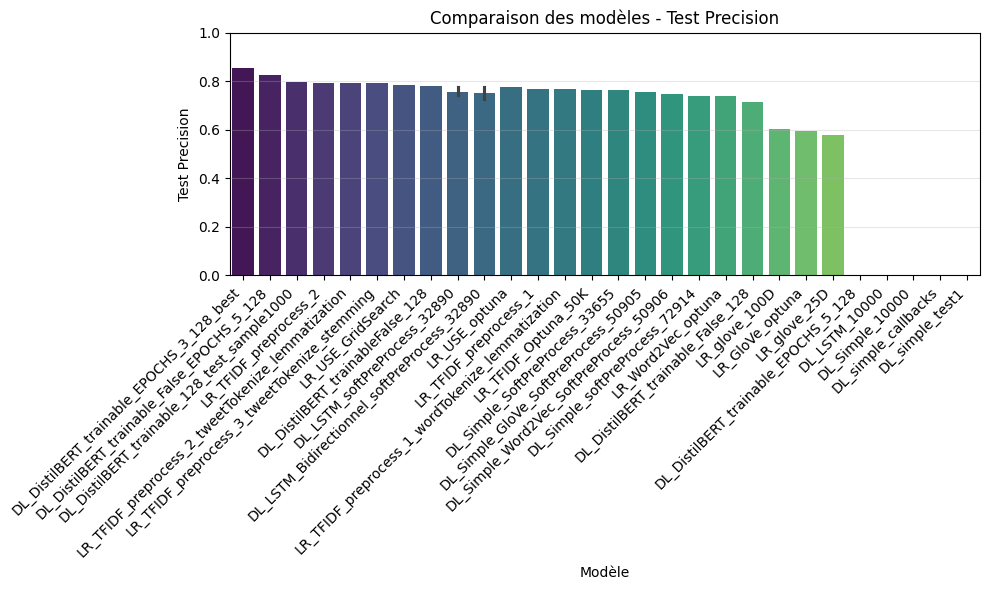

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_performances,
    x="model",
    y="test_precision",
    palette="viridis",
)
plt.title("Comparaison des modèles - Test Precision")
plt.xlabel("Modèle")
plt.ylabel("Test Precision")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

Sauvegarder le tokenizer du run choisi

In [29]:
# Fermer le run actif
mlflow.end_run()
# Sauvegarder le tokenizer du run choisi
run_id = "5a89fbda32b94805ad6be4503dd28893"
# Charger le tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# Sauvegarder le tokenizer
tokenizer.save_pretrained(f"tokenizer_{run_id}")
# Enregistrer dans MLflow
with mlflow.start_run(run_id=run_id):
    mlflow.log_artifacts("temp_tokenizer_dir", artifact_path="tokenizer")